# Exploratory NLP on chat messages in pilot data

To do:
-- try different tokenizer to deal with punctuation?
-- bag of tower model (tower pairs: group L/C and C/L)
    for each pair, compare first and last occurance of a specific BOT
    interested in words that drop out and words that increase in frequency
-- fix dictionary to be union not intersection
-- TFIDF for tower specific 
    what are the specific words we use to describe tower pairs
-- condition on rep 1, use same langauge for all three items, do subjects disambiguate by the later trials

-- compare probability of words for L-pi and L-C in early and late stages (factor out the "L") 

[X] try tf-idf with LC as doc 1 and LP,CP combined as doc 2 in final rep 

## Import packages

In [1]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from collections import Counter
from num2words import num2words
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import matutils, models
import matplotlib.pyplot as plt

import nltk
import os
import string
import numpy as np
import copy
import pandas as pd
pd.set_option('display.max_colwidth', 1000)
import pickle
import re
import math


stemmer = SnowballStemmer("english")

## Import data frames (generated in DF_generator script from mongoDB)

In [2]:
df_chat = pd.read_csv('df_chat.csv')
print(df_chat.shape)
print("Dyads:",len(df_chat.gameid.unique()))

(3066, 21)
Dyads: 71


### Check exclusion criteria

In [3]:
df_trial = pd.read_csv('df_trial.csv')
df75 = pd.DataFrame(df_trial.groupby(['gameid', 'trialNum'])['trialScore'].sum()>75).groupby(['gameid']).sum()
df75['trials'] = df75['trialScore']

#delete rows that aren't greater than 75% in 9 trials
df75 = df75[df75['trials']>=9]

print("Total dyads achieving 75% Accuracy on 75% of trials:",len(df75))

Total dyads achieving 75% Accuracy on 75% of trials: 48


### Remove dyads that did not pass exclusion criteria

In [4]:
keep_id = df75.index.tolist()
keep_id
df = df_chat[df_chat['gameid'].isin(keep_id)]
print(df.shape)
print("Passed Dyads:",len(df.gameid.unique()))

(2223, 21)
Passed Dyads: 48


In [5]:
df = df[['gameid','repNum','content','trialNum', 'leftTarget', 'rightTarget']]
df = df[df.trialNum != 'practice']
df = df[df.repNum != 'practice']
df['C'] = (df['leftTarget'] + df['rightTarget']).apply(lambda x: 1 if 'C' in x   else 0)
df['L'] = (df['leftTarget'] + df['rightTarget']).apply(lambda x: 1 if 'L' in x   else 0)
df['P'] = (df['leftTarget'] + df['rightTarget']).apply(lambda x: 1 if 'Pi' in x   else 0)
df = df.drop(['leftTarget', 'rightTarget'],axis = 1)
df.head(2)


,gameid,repNum,content,trialNum,C,L,P
2,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,0,put a blue block three from the left~~~,0,1,0,1
3,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,0,place a red block on top of the left side of the blue block and then another red on top of that red,0,1,0,1


## Create Bag of Words for each repNum by concatenating content
create df with column for repnum and column for entire string grouped by repnum

In [6]:
# df['BOW'] = df[['repNum','C','L','Pi','content']].groupby(['repNum','C','L','Pi'])['content'].transform(lambda x: ' '.join(x))
# df = df[['repNum','C','L','Pi','BOW']]
df = df.groupby(['gameid','repNum','C','L','P'])['content'].apply(lambda x: ' '.join(x)).reset_index()

print(df.shape)
df.head(2)

(576, 6)


,gameid,repNum,C,L,P,content
0,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,0,1,1,"two blue blocks on left and right side of left right line two red block on top of left blue block just placed down two red block one space apart on right line one blue block on top red block on left red line, on more red block on top of left red block"
1,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,1,0,1,"for left red line, place blue block in the middle then stack two red on left side of that blue block for left red line, place blue block on highest red so it stick out on the right side for right red line, place one red block two space away from that line, same as step 3, but on the left side, so there is two spaces apart between those two red blocks for right red line, place one blue block on top of each red block so the blue blocks meet/touch"


In [7]:
df_chat.isnull().sum()

Unnamed: 0                      0
_id                             0
iterationName                   0
gameid                          0
time                            0
assignmentId                    0
leftTarget                      0
rightTarget                     0
trialNum                      112
turnNum                         0
repNum                          0
content                         0
timeElapsedInTurn               0
timeElapsedInTrial              0
eventType                       0
individualPracticeAttempts    938
turnStartTime                 980
trialStartTime                980
practice                      980
word_count                      0
char_count                      0
dtype: int64

### Remove stopwords

In [8]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['BOW_clean'] = df['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [9]:
df['BOW_clean'] = df['BOW_clean'].str.lower()
df['BOW_clean'] = df['BOW_clean'].str.replace(r'~', '')
df['BOW_clean'] = df['BOW_clean'].str.replace(r'\(', '')
df['BOW_clean'] = df['BOW_clean'].str.replace(r'\)', '')
df['BOW_clean'] = df['BOW_clean'].str.replace(r'\,', '')
df['BOW_clean'] = df['BOW_clean'].str.replace(r"\'", '')
df['BOW_clean'] = df['BOW_clean'].str.replace(r"\:", '')
df.head(2)

,gameid,repNum,C,L,P,content,BOW_clean
0,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,0,1,1,"two blue blocks on left and right side of left right line two red block on top of left blue block just placed down two red block one space apart on right line one blue block on top red block on left red line, on more red block on top of left red block",two blue blocks left right side left right line two red block top left blue block placed two red block one space apart right line one blue block top red block left red line red block top left red block
1,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,1,0,1,"for left red line, place blue block in the middle then stack two red on left side of that blue block for left red line, place blue block on highest red so it stick out on the right side for right red line, place one red block two space away from that line, same as step 3, but on the left side, so there is two spaces apart between those two red blocks for right red line, place one blue block on top of each red block so the blue blocks meet/touch",left red line place blue block middle stack two red left side blue block left red line place blue block highest red stick right side right red line place one red block two space away line step 3 left side two spaces apart two red blocks right red line place one blue block top red block blue blocks meet/touch


In [10]:
import nltk
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in tokenizer.tokenize(text)]
df['BOW_lemmatized'] = df['BOW_clean'].apply(lemmatize_text)
df.head(1)

,gameid,repNum,C,L,P,content,BOW_clean,BOW_lemmatized
0,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,0,1,1,"two blue blocks on left and right side of left right line two red block on top of left blue block just placed down two red block one space apart on right line one blue block on top red block on left red line, on more red block on top of left red block",two blue blocks left right side left right line two red block top left blue block placed two red block one space apart right line one blue block top red block left red line red block top left red block,"[two, blue, block, left, right, side, left, right, line, two, red, block, top, left, blue, block, placed, two, red, block, one, space, apart, right, line, one, blue, block, top, red, block, left, red, line, red, block, top, left, red, block]"


### Build a matrix of each word in the corpus and its TF-IDF for that comment

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = df['BOW_clean']
vectorizer = TfidfVectorizer(sublinear_tf = True)
vectors = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df_vectors = pd.DataFrame(denselist, columns=feature_names)

### Select the top 5 words (TF-IDF) for each comment
##### Intuitively, this roughly corresponds to what this person is talking about relatively more than any other person

In [12]:
Tops = pd.DataFrame(df_vectors.apply(lambda x:list(df_vectors.columns[np.array(x).argsort()[::-1][:15]]), axis=1).to_list())

Tops

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,block,apart,line,two,red,top,one,placed,blue,left,space,right,blocks,side,ends
1,stick,step,line,place,block,two,apart,touch,highest,away,red,meet,side,blocks,blue
2,line,sticks,place,block,stacked,highest,red,two,blocks,far,blue,top,side,placed,left
3,meet,line,middle,block,apart,touch,red,two,blocks,one,spaces,blue,left,right,side
4,line,construction,block,exact,faces,apart,red,highest,one,side,round,previous,two,stack,spaces
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,mark,tick,hang,opposite,close,take,two,squares,center,place,edge,blues,stacked,reds,blue
572,take,mark,edge,stack,place,last,tick,let,hang,one,reds,center,two,blue,block
573,tick,opposite,close,take,two,squares,mark,edge,stack,blues,side,placed,next,reds,another
574,oppoiste,ion,tick,close,hanging,do,two,squares,center,mark,stack,blues,side,reds,blue


## Okay, that was a dud, let's just plot histograms of word frequency for each repNum

## Build Towerset and dyad specific BOW separated by first and last rep

In [38]:
tower1 = 'C'
tower2 = 'L'
word_list = []
gameid = df['gameid'].unique()
for game in gameid:
    set1 = df.loc[(df[tower1] == 1) & (df[tower2] == 1) & (df['gameid'] == game), 'BOW_clean'].iloc[0].split()
    set2 = df.loc[(df[tower1] == 1) & (df[tower2] == 1) & (df['gameid'] == game), 'BOW_clean'].iloc[3].split()
    #Get word counts for first set
    counts = Counter(set1)
    total = sum(counts.values())
    d1 = {k: v / total for k, v in counts.items()}
    #Get word counts for second set
    counts = Counter(set2)
    total = sum(counts.values())
    d2 = {k: v / total for k, v in counts.items()}
    labels, values = zip(*counts.items())

    #Get difference in count dicts
    d_diff = {key: d2[key] - d1.get(key, 0) for key in d2}
    words = list({k: v for k, v in sorted(d_diff.items(), key=lambda item: item[1], reverse = True)}.items())[:5]
    word_list.append(words)


In [40]:
out = pd.DataFrame({'gameid':gameid,'word_list':word_list})

In [42]:
print(out.shape)
out

(48, 2)


,gameid,word_list
0,0110-5784fec9-109a-4d7a-a343-4820f4d42144,"[(side, 0.031578947368421054), (line, 0.028070175438596495), (one, 0.02690058479532164), (middle, 0.02690058479532164), (blue, 0.023391812865497075)]"
1,0208-b497c845-b076-45c9-b958-a62a3ae6e65f,"[(1, 0.2), (tall, 0.1), (c, 0.1), (3, 0.1), (big, 0.1)]"
2,0662-7a9212c9-5aa7-44de-9ed7-4663c56562d2,"[(long, 0.17222222222222222), (spots, 0.17222222222222222), (c, 0.07222222222222223), (2, 0.07222222222222223), (l, 0.07222222222222223)]"
3,0738-513adaa7-2548-44a4-8d01-7e2fb3ecbfd4,"[(tall, 0.1111111111111111), (c, 0.1111111111111111), (l, 0.1111111111111111), (right!, 0.1111111111111111), (youre, 0.1111111111111111)]"
4,0741-0d5c3f38-e1fa-4a05-9f35-4a81c7cdbd71,"[(line, 0.10351966873706003), (horizontal, 0.05175983436853002), (red, 0.049689440993788817), (buddy, 0.047619047619047616), (vertical, 0.02795031055900621)]"
5,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,"[(tall, 0.16666666666666666), (starting, 0.12745098039215685), (grid, 0.12745098039215685), (c-shape, 0.08333333333333333), (third, 0.08333333333333333)]"
6,1690-8f854c73-420c-4820-b76f-2c2ac28a3035,"[(left, 0.09154437456324248), (1, 0.07407407407407407), (top, 0.05520614954577219), (2, 0.0363382250174703), (stacked, 0.0363382250174703)]"
7,2083-6615b44d-57a8-4953-beca-afa15df0c195,"[(build, 0.125), (shape, 0.125), (l, 0.0625), (identical, 0.0625), (c, 0.0625)]"
8,2391-2f396ec8-517f-4681-b366-51f930bcac22,"[(one, 0.05388471177944862), (place, 0.05012531328320802), (blues, 0.047619047619047616), (left, 0.042606516290726815), (going, 0.03007518796992481)]"
9,2409-8e3cd70d-3066-4782-9d23-e3fecd179ac1,"[(c, 0.2), (r, 0.2), (8, 0.075), (blue, 0.05833333333333334), (4, 0.05)]"


## WORD CLOUD!
perhaps pointless, but definitely fun!

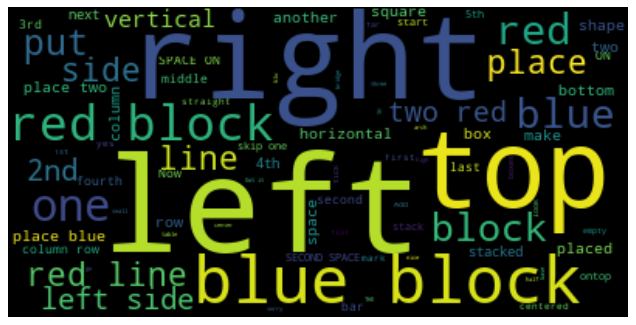

In [159]:
from wordcloud import WordCloud
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
wordcloud = WordCloud().generate(df['BOW_clean'].iloc[1])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


## Try TF-IDF with tower specific docs

In [214]:
CP_3 = df.loc[(df['C'] == 1) & (df['P'] == 1), 'BOW_clean'].iloc[3]
CL_3 = df.loc[(df['C'] == 1) & (df['L'] == 1), 'BOW_clean'].iloc[3]
LP_3 = df.loc[(df['L'] == 1) & (df['P'] == 1), 'BOW_clean'].iloc[3]

doc1 = "hello this this this this this two five ten"
doc2 = "Other thing this this this this this two hello else"

vectorizer = TfidfVectorizer(sublinear_tf = True)
vectors = vectorizer.fit_transform([doc1,doc2])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df_vectors = pd.DataFrame(denselist, columns=feature_names)

Tops = pd.DataFrame(df_vectors.apply(lambda x:list(df_vectors.columns[np.array(x).argsort()[::-1][:15]]), axis=1).to_list())

Tops

,0,1,2,3,4,5,6,7
0,this,ten,five,two,hello,thing,other,else
1,this,thing,other,else,two,hello,ten,five


In [212]:
len(doc1)

839